# Sea Ice Advance and Retreat

Using the daily NSIDC sea ice extent product, figure out the day in each year when sea ice is present in each pixel to calculate day of sea ice advance and retreat, and the duration between thw two

In [1]:
#directory paths
_work_dir='/g/data/jk72/as2285/miz/'
_data_dir='/g/data/jk72/MIZ/'

In [2]:
#useful py libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import odc.geo.xr

In [3]:
import sys
sys.path.append(_work_dir)

from utils.sea_ice_duration import sea_ice_duration

%run {_work_dir}utils/plot_tools.ipynb

In [4]:
%matplotlib inline

In [5]:
#some constants
CLIMAT_DATES=[1981,2010]
EAST_ANT_LONS=[71,160] #longitudes for east Antartica (easterly)
YEAR=2021


# Open the dataset

In [6]:
#lists of both the historical and near real-time files
daily_files = ! ls -d {_data_dir}NSIDC/G02202_V4/seaice_conc_daily*.nc {_data_dir}NSIDC/G10016_V2/daily/*.nc

In [7]:
#open it all
cdr_daily_ds=xr.open_mfdataset(
    daily_files, combine='nested',concat_dim='tdim', data_vars='minimal',
).swap_dims(
    {'tdim':'time'}#, 'x':'xgrid','y':'ygrid'}
).rename(
    {'xgrid':'x','ygrid':'y'}
)  

In [8]:
cdr_daily_ds=cdr_daily_ds.odc.assign_crs("EPSG:3412")

# Calculate advance day / retreat day and season

For year of the groups defined (stating/ending Feb 15), find the day when advance and retreat starts:

In [9]:
cdr_duration=sea_ice_duration(cdr_daily_ds.cdr_seaice_conc)

In [10]:
cdr_duration.calc_duration()

In [11]:
adv_day_ds=cdr_duration.adv_day_ds
ret_day_ds=cdr_duration.ret_day_ds
duration_da=cdr_duration.duration_da

In [12]:
cdr_duration.calc_climat()

In [13]:
cdr_duration.calc_anoms()

In [14]:
YEAR=2021

# Saving pngs for ipyleaflet

Example of saving mpl plots to png, and then opening in ipyleaflet from the file.

In [35]:
data_urls=list()

for i in [YEAR]:#cdr_duration.dur_anom_da.year.values:

    to_plot_da=cdr_duration.dur_anom_da.sel(year=i)

    plt.figure(figsize=(16,16))
    ax=plt.subplot(projection=ccrs.SouthPolarStereo(true_scale_latitude=-71))

    cs = plt.contourf(
        to_plot_da.x,
        to_plot_da.y,
        to_plot_da,
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='coolwarm_r',
        levels=np.arange(-70,71,20),
        extend='neither'
    )
    
    ax.set_extent([-3950000.0,3950000.0,-3950000.0,4350000.0], crs=ccrs.SouthPolarStereo(true_scale_latitude=-70))

    #s = io.BytesIO()
    plt.savefig(f'{_work_dir}figures/duration/duration/{i}.png', format='png', bbox_inches="tight", transparent="True")
    plt.close()
    #s = base64.b64encode(s.getvalue()).decode("utf-8").replace("\n", "")
    #data_urls.append('data:image/png;base64,%s' % s) 

Convert bounds to lat/lon for spstere

In [36]:
cdr_duration.dur_anom_da.odc.geobox.boundary

<bound method GeoBox.boundary of GeoBox((332, 316), Affine(25000.0, 0.0, -3950000.0,
       0.0, -25000.0, 4350000.0), CRS('EPSG:3412'))>

In [37]:
cdr_duration.dur_anom_da.odc.geobox.extent.exterior.points


[(-3950000.0, 4350000.0),
 (-3950000.0, -3950000.0),
 (3950000.0, -3950000.0),
 (3950000.0, 4350000.0),
 (-3950000.0, 4350000.0)]

In [38]:
(x1, y1), _, (x2, y2) = cdr_duration.dur_anom_da.odc.geobox.extent.exterior.to_crs("EPSG:4326").points[:3]
bounds = [[y1, x1], [y2, x2]]

bounds

[[-39.23088840027726, -42.24089234137973], [-41.44695467739651, 135.0]]

Open the file

In [39]:
import io
import base64

s=io.FileIO(f'{_work_dir}figures/duration/duration/{YEAR}.png')

#from PIL import Image
s = base64.b64encode(s.read()).decode("utf-8").replace("\n", "")
data_urls=('data:image/png;base64,%s' % s) 

Check the size

In [40]:
import sys
sys.getsizeof(data_urls)

68479

Open

In [41]:
from ipyleaflet import Map, basemaps, ImageOverlay, projections
from ipywidgets import Layout


spsLayout=Layout(width='600px', height='600px')

m = Map(basemap=basemaps.NASAGIBS.BlueMarble3031, center=(-80, 135), zoom=1, crs=projections.EPSG3031, layout=spsLayout)

m.add_layer(
    ImageOverlay(url=data_urls, bounds=bounds, opacity=1)
)

m

Map(center=[-80, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

# Another way to save vector filled contours?

Saving the filled contours as polygons and plotting those instead

Create polygons from the output of contourf and show those 

In [22]:
to_plot_da=cdr_duration.dur_anom_da.sel(year=YEAR)

In [23]:
from utils.contourf_polygons import contourf_polygons

#calculate the polygons

gdf=contourf_polygons(
    to_plot_da, 
    levels=np.arange(-70,71,20),
    )

In [24]:
#save it to a file for later use

gdf.to_file(f'{_work_dir}/data/test_gdf.json') 

del(gdf)

In [25]:
from geopandas.geodataframe import GeoDataFrame

gdf=GeoDataFrame.from_file(f'{_work_dir}/data/test_gdf.json')

In [42]:
# plot  the polygon vectors
from ipyleaflet import Map, basemaps, GeoData, LayerGroup, LayersControl, LegendControl
import matplotlib.colors as mplcolors
import matplotlib.cm

levels=gdf.level.unique()

#extract a colour for each level
cmap = matplotlib.cm.get_cmap('coolwarm_r')
colors = [mplcolors.rgb2hex(cmap(i)) for i in np.arange(0,1.01,(1/(len(levels)-1)))] 

#load each contour level as a seperate GeoData layer    
geodata_ls=[
    GeoData(
        geo_dataframe=gdf.where(gdf.level==float(levels[iLevel])),
        style={'color': colors[iLevel], 'fillColor': colors[iLevel], 'opacity':0.75, 'weight':1.9, 'dashArray':'2', 'fillOpacity':1},
    )
    for iLevel in range(len(levels))
]

#group the contours all together
grouped_layers=LayerGroup(layers=geodata_ls, name=f'{YEAR} Duration Anomalies')

#somewhere to show the results
spsLayout=Layout(width='600px', height='600px')
zoom = 0.85
center = [-70, 130]
map = Map(basemap=basemaps.NASAGIBS.BlueMarble3031, center=center, zoom=zoom, crs=projections.EPSG3031, layout=spsLayout )
map.add_layer(grouped_layers);

control = LayersControl(position='topright')
map.add_control(control)

#to-do: add legend

map

Map(center=[-70, 130], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

# A future basemap?

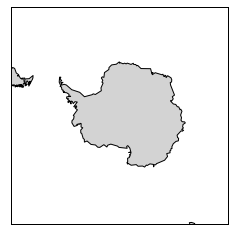

In [27]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
# setup Lambert Conformal basemap.
antons_basemap = Basemap(projection='spstere',
            resolution='c',lon_0=180, boundinglat=-50)
# draw coastlines.
antons_basemap.drawcoastlines()
# draw a boundary around the map, fill the background.
# this background will end up being the ocean color, since
# the continents will be drawn on top.
antons_basemap.drawmapboundary()#fill_color='aqua')
# fill continents, set lake color same as ocean color.
antons_basemap.fillcontinents(color='lightgray')
plt.show()

# A way of making contour lines

In [28]:
from dea_tools.spatial import subpixel_contours
from affine import Affine

In [29]:
to_plot_da.load()

<xarray.DataArray (y: 332, x: 316)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    year         int64 2021
  * x            (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
  * y            (y) float32 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
    spatial_ref  int32 3412

In [30]:
lines=subpixel_contours(to_plot_da, z_values=[0,-20],#np.arange(-70,71,20),
                        crs='EPSG:3031', affine=Affine(1,0,0,0,1,0))

In [31]:
lines

,z_value,geometry
0,0,"MULTILINESTRING ((-2237500.000 1269446.486, -2..."
1,-20,"MULTILINESTRING ((137500.000 3994801.909, 1479..."


<AxesSubplot:>

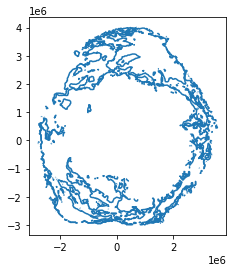

In [32]:
lines.plot()

1. How to create a holy polygon, using built in ipyleaflet classes

In [33]:
from ipyleaflet import Polygon

multi_polygon=Polygon(
    locations=[
        [(-70,135),(-70,145),(-80, 145)],
        [(-75,138),(-75,142),(-78, 144)]
    ],
    color='green'
)


In [43]:
from ipyleaflet import Map, basemaps, ImageOverlay, projections, basemap_to_tiles
from ipywidgets import Layout

spsLayout=Layout(width='600px', height='600px')

m = Map(basemap=basemaps.NASAGIBS.BlueMarble3031, center=(-80, 135), zoom=1, crs=projections.EPSG3031, layout=spsLayout)

m.add_layer(multi_polygon)

m

Map(center=[-80, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…